# Package Imports

The necessary packages for implementing a model for recognizing the activity of a human from the data from sensors of a mobile.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import datasets
The train and test data are being imported in the current runtime. The pandas library is used for reading the csv files. 

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Visualising and cleaning data (Preprocessing)

In [3]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

In [4]:
train.Activity.value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [5]:
test.Activity.value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64

In [6]:
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b

In [7]:
basic_details(train)

,Missing value,N unique value,dtype
tBodyAcc-mean()-X,0,7347,float64
tBodyAcc-mean()-Y,0,7352,float64
tBodyAcc-mean()-Z,0,7349,float64
tBodyAcc-std()-X,0,7349,float64
tBodyAcc-std()-Y,0,7351,float64
...,...,...,...
"angle(X,gravityMean)",0,7352,float64
"angle(Y,gravityMean)",0,7352,float64
"angle(Z,gravityMean)",0,7352,float64
subject,0,21,int64


In [8]:
basic_details(test)

,Missing value,N unique value,dtype
tBodyAcc-mean()-X,0,2947,float64
tBodyAcc-mean()-Y,0,2947,float64
tBodyAcc-mean()-Z,0,2947,float64
tBodyAcc-std()-X,0,2947,float64
tBodyAcc-std()-Y,0,2947,float64
...,...,...,...
"angle(X,gravityMean)",0,2947,float64
"angle(Y,gravityMean)",0,2947,float64
"angle(Z,gravityMean)",0,2947,float64
subject,0,9,int64


In [9]:
def dataPreprocessing(df):
    df['subject'] = '#' + df['subject'].astype('str')
    df['Activity'] = df.Activity.astype('category').cat.codes
    return df

In [10]:
train = dataPreprocessing(train)
test = dataPreprocessing(test)

In [11]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,#1,2
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,#1,2
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.2

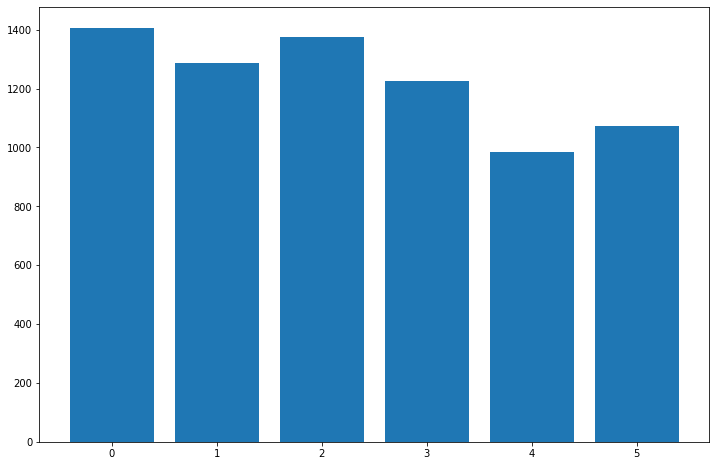

In [12]:
activityTr = train['Activity']
activityTs = test['Activity']
label_counts = activityTr.value_counts()

plt.figure(figsize= (12, 8))
plt.bar(label_counts.index, label_counts)
plt.show()

# Scaling and Dimension Reduction.
Scaling of data fit for Dl models and Applying dimension reduction using Principle Component Analysis for better accuracy

In [13]:
train['Data'] = 'Train'
test['Data'] = 'Test'
both = pd.concat([train,test], axis=0).reset_index(drop=True)
activity = both.Activity
both = both.drop(['Data'], axis=1)
both=both.drop(['subject','Activity'], axis=1)

In [14]:
scale = StandardScaler()
both = scale.fit_transform(both)

In [15]:
pca = PCA(n_components=0.9, random_state=0)
both= pca.fit_transform(both)

# Split data into Features and labels. 
All rows except subject is taken as X, and Activity is taken as label

In [16]:
X_train, X_test, y_train, y_test = train_test_split(both, activity, test_size = 0.2, random_state = 0)

Converting y_train data into a categorical form to fit it to the output layer of the neural network

In [17]:
Y_train = np_utils.to_categorical(y_train)

In [18]:
X_train.shape

(8239, 65)

In [19]:
X_test.shape

(2060, 65)

# Building model with keras and tensorflow

Creating checkpoint function for callback and storing the best weights of the neural net in drive

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
filename = '/content/drive/My Drive/Colab Notebooks/RecognitionWeights.h5'
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', save_best_only = True, mode = 'min')

In [22]:
def createModel():
    model = Sequential()
    model.add(Dense(65, input_dim = X_train.shape[1], activation = 'relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(45, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model

In [23]:
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65)                4290      
_________________________________________________________________
dropout (Dropout)            (None, 65)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                2970      
_________________________________________________________________
dropout_1 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 276       
Total params: 7,536
Trainable params: 7,536
Non-trainable params: 0
_________________________________________________________________


# Training the model

In [24]:
model.fit(X_train,Y_train, epochs = 1000, use_multiprocessing=True, validation_split=0.15, callbacks=[checkpoint])

Epoch 1/1000
219/219 [==============================] - 1s 5ms/step - loss: 1.0759 - accuracy: 0.6310 - val_loss: 0.3214 - val_accuracy: 0.8746
Epoch 2/1000
219/219 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.8338 - val_loss: 0.2121 - val_accuracy: 0.9280
Epoch 3/1000
219/219 [==============================] - 0s 2ms/step - loss: 0.3063 - accuracy: 0.8773 - val_loss: 0.1708 - val_accuracy: 0.9377
Epoch 4/1000
219/219 [==============================] - 0s 2ms/step - loss: 0.2364 - accuracy: 0.9072 - val_loss: 0.1497 - val_accuracy: 0.9466
Epoch 5/1000
219/219 [==============================] - 0s 2ms/step - loss: 0.2084 - accuracy: 0.9146 - val_loss: 0.1443 - val_accuracy: 0.9539
Epoch 6/1000
219/219 [==============================] - 0s 2ms/step - loss: 0.1857 - accuracy: 0.9259 - val_loss: 0.1336 - val_accuracy: 0.9531
Epoch 7/1000
219/219 [==============================] - 0s 2ms/step - loss: 0.1713 - accuracy: 0.9323 - val_loss: 0.1422 - val_accuracy:

In [25]:
ValuationModel = createModel()
ValuationModel.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 65)                4290      
_________________________________________________________________
dropout_2 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 45)                2970      
_________________________________________________________________
dropout_3 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 276       
Total params: 7,536
Trainable params: 7,536
Non-trainable params: 0
_________________________________________________________________


In [26]:
ValuationModel.load_weights(filename)

# Prediction
Testing the model with the test data by predicting the labels y_test

In [27]:
y_pred=np.argmax(ValuationModel.predict(X_test), axis=-1)

In [28]:
z = np.array(y_test)

In [29]:
print('Accuracy: ',accuracy_score(z, y_pred)*100)

Accuracy:  96.31067961165049
